In [1]:
import pandas as pd
from datetime import datetime, timedelta 
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('minute_candle.xlsx - Sheet1.csv')
df.CreatedOn = pd.to_datetime(df.CreatedOn)

In [3]:
df.dropna(axis=1 , inplace=True)

In [4]:
def clean_data(df , ticker , start_date , end_date):
#     Get the data of the given ticker
    df = df[df['InstrumentIdentifier'] == ticker]
    df.dropna(axis=1,inplace=True)
    
    
#    define a function to round up the seconds to nearest minute
    def round_seconds_to_minutes(dt):
        rounded_minute = dt.minute
        if dt.second >= 30:
            rounded_minute += 1
        return datetime(dt.year, dt.month, dt.day, dt.hour, rounded_minute)
    
    
#   apply the funciton 
    df.CreatedOn = df['CreatedOn'].apply(lambda x: round_seconds_to_minutes(x))
    
    
# drop the duplicates that are generated after rounding 
    df = df.drop_duplicates(subset='CreatedOn')
    
# define function to fill missing value
    def fill_missing_value(df):
        df['CreatedOn'] = pd.to_datetime(df['CreatedOn'])
        df['Date'] = df['CreatedOn'].dt.date
        date_list = list(set(df['Date']))
        final_df = pd.DataFrame(columns = df.columns)
    
#         iterate every date to fill missing value at that particular date and store in a dataframe
        for date in date_list:
            temp = df[df['Date'] == date].copy()
            mi = pd.Timestamp(f'{date} 09:00:00')
            ma = pd.Timestamp(f'{date} 15:30:00')
            time_range = pd.date_range(start=mi, end=ma, freq='1T')
            temp = temp.set_index('CreatedOn').reindex(time_range).interpolate().reset_index()
            final_df = final_df.append(temp)
        return final_df
    
    df = fill_missing_value(df)
    df['CreatedOn'] = df['index']
    df.sort_values(by=['CreatedOn'])
    return df

In [5]:
def strat(df , freq , stop_loss , target_profit , window, std):
    
    ans = pd.DataFrame(columns = ['Date' , 'number of trades' , 'number of winning trades' , 'number of lossing trades' , 'Average gain (winning)' , 'Average loss (lossing)' , 'cumulative returns'])
    df = df[[ 'CreatedOn' , 'CloseValue' , 'OpenValue' ]]
    df['CreatedOn'] = pd.to_datetime(df['CreatedOn'])
    df['Date'] = df['CreatedOn'].dt.date
    date_list = list(set(df['Date']))
    
    
    for date in date_list:
        x = pd.DataFrame()
        temp = df[df['Date'] == date].copy()
        mi = pd.Timestamp(f'{date} 09:00:00')
        ma = pd.Timestamp(f'{date} 15:30:00')
        time_range = pd.DataFrame({'CreatedOn':pd.date_range(start=mi, end=ma, freq=f'{freq[:-1]}T')})
        x = pd.merge(temp, time_range, on="CreatedOn", how="inner")
        
        x['sma'] = x.CloseValue.rolling(window=window).mean()
        x['stddev'] = x.CloseValue.rolling(window=window).std()
        x['Upper'] = x.sma + x.stddev*std
        x['Lower'] = x.sma - x.stddev*std
        
        x['buy'] = np.where(x.Lower > x.CloseValue , True , False)
        x['sell'] = np.where(x.Upper < x.CloseValue , True , False)
        x.dropna(inplace=True)
        summary = pd.DataFrame(columns=['start_time', 'end_time' ,'reason'])
        start_time = []
        end_time = []

        reason = []
        buys = []
        sells = []
        pos = False
        last_buy_price =0
        
        
        for i in range(len(x)):
            if x.Lower.iloc[i] > x.CloseValue.iloc[i] and str(x.CreatedOn.iloc[i]) !=  str(time_range.iloc[-2]) :
                if pos == False:
                    buys.append(i)
                    pos= True
                    last_buy_price = x.CloseValue.iloc[i]
                    start_time.append(str(x.CreatedOn.iloc[i]))
                    
            elif (x.CloseValue.iloc[i] <= (1-stop_loss)*last_buy_price):
                 if pos:
                    sells.append(i)
                    pos= False      
                    reason.append('Stop loss')
                    end_time.append(str(x.CreatedOn.iloc[i]))
            elif (last_buy_price*(1+target_profit) <= x.CloseValue.iloc[i]):
                if pos:
                    sells.append(i)
                    pos= False
                    reason.append('Achieved Target Profit')
                    end_time.append(str(x.CreatedOn.iloc[i]))
            elif  (x.Upper.iloc[i] < x.CloseValue.iloc[i]) :
                if pos:
                    sells.append(i)
                    pos= False
                    reason.append('Upper band')
                    end_time.append(str(x.CreatedOn.iloc[i]))
                    
        if len(buys) != len(sells):
            sells.append(i)
            reason.append('End of Day')
            end_time.append(str(x.CreatedOn.iloc[i]))
        
        
        n_trades = len(buys)
        a = list(x.iloc[buys].CloseValue) 
        b = list(x.iloc[sells].CloseValue)
        c = pd.DataFrame({'buy':a , 'sell':b})
        c['profit'] =100*(c.sell - c.buy)/c.buy
        profits = list(c.profit)
        n_wins = sum(1 for value in profits if value > 0)       
        n_loss = n_trades - n_wins
        max_loss = min(profits) if len(profits) >0 else 0
        avg_gain = sum(value for value in profits if value > 0)/(n_wins)  if n_wins > 0 else 0
        avg_loss = sum(value for value in profits if value < 0)/(n_loss)  if n_loss > 0 else 0
        
        
        m = 1
        for p in profits:
            m *= (1 + p)
        c_return = m
      
        ans = ans.append( { 'Date':date,
          'number of trades':n_trades , 
         'number of winning trades' :n_wins,
         'number of lossing trades' :n_loss,
         'Average gain (winning)':avg_gain , 
         'Average loss (lossing)' :avg_loss,
         'cumulative returns':c_return},ignore_index=True)
        summary['start_time'] = start_time
        summary['end_time'] = end_time
        summary['reason'] = reason
        
        print('-'*20+f'summary for {date} '+'-'*20)
        print(summary)
        
        
        plt.figure(figsize=(10,5))
        plt.title('daily plot with entries and exits shown')
        plt.plot(x[['CloseValue' , 'Upper' , 'Lower']])
        plt.fill_between(x.index , x.Upper , x.Lower , color='grey' , alpha=0.5)
        plt.scatter(x.iloc[buys].index , x.iloc[buys].CloseValue , marker='^' , color='g')
        plt.scatter(x.iloc[sells].index , x.iloc[sells].CloseValue , marker='^' , color='r')
        plt.show()
    return ans

In [6]:
def run(data , ticker , start_date , end_date , freq , stop_loss , target_profit , window, std ):
    clean_dataset = clean_data(df , ticker , start_date, end_date)
    stats = strat(clean_dataset , freq , stop_loss , target_profit  , window, std)
    profits = list(stats['cumulative returns'])
    pnl = []
    temp = 10000
    for i in profits:
        pnl.append(temp*i)
        temp = temp*i

    plt.figure(figsize=(10,5))
    plt.title('Total PnL')
    plt.plot(pnl, marker='o')
    plt.show()
    print('-'*20 +'Stats' + '-'*20)
    print(stats)

--------------------summary for 2023-07-31 --------------------
            start_time             end_time      reason
0  2023-07-31 10:35:00  2023-07-31 10:56:00  Upper band
1  2023-07-31 11:09:00  2023-07-31 11:44:00  Upper band
2  2023-07-31 12:25:00  2023-07-31 12:47:00  Upper band
3  2023-07-31 13:03:00  2023-07-31 13:11:00  Upper band
4  2023-07-31 13:19:00  2023-07-31 13:22:00  Upper band
5  2023-07-31 13:29:00  2023-07-31 13:38:00  Upper band
6  2023-07-31 13:55:00  2023-07-31 14:29:00  Upper band
7  2023-07-31 14:35:00  2023-07-31 14:52:00  Upper band
8  2023-07-31 15:12:00  2023-07-31 15:30:00  End of Day


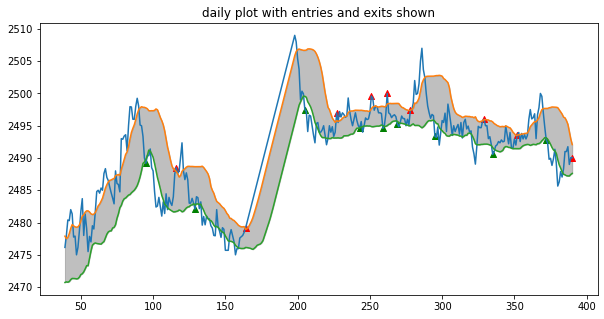

--------------------summary for 2023-08-09 --------------------
             start_time             end_time                  reason
0   2023-08-09 09:19:00  2023-08-09 09:22:00  Achieved Target Profit
1   2023-08-09 09:38:00  2023-08-09 09:52:00              Upper band
2   2023-08-09 10:00:00  2023-08-09 10:12:00              Upper band
3   2023-08-09 10:33:00  2023-08-09 10:37:00              Upper band
4   2023-08-09 10:53:00  2023-08-09 11:06:00              Upper band
5   2023-08-09 11:29:00  2023-08-09 11:41:00              Upper band
6   2023-08-09 12:12:00  2023-08-09 12:45:00              Upper band
7   2023-08-09 13:25:00  2023-08-09 13:27:00              Upper band
8   2023-08-09 13:55:00  2023-08-09 14:00:00              Upper band
9   2023-08-09 14:03:00  2023-08-09 14:26:00              Upper band
10  2023-08-09 14:30:00  2023-08-09 14:33:00              Upper band
11  2023-08-09 14:56:00  2023-08-09 15:15:00              Upper band
12  2023-08-09 15:20:00  2023-08-09 15:

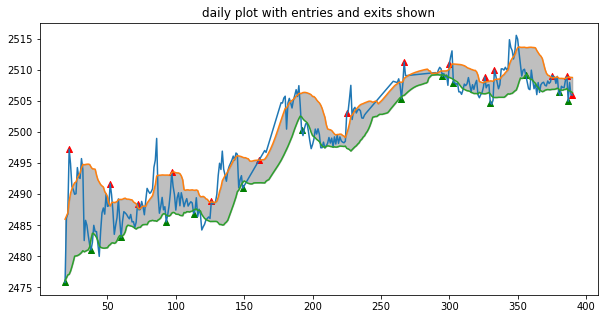

--------------------summary for 2023-08-01 --------------------
             start_time             end_time      reason
0   2023-08-01 09:28:00  2023-08-01 09:56:00   Stop loss
1   2023-08-01 09:58:00  2023-08-01 10:07:00  Upper band
2   2023-08-01 10:11:00  2023-08-01 10:52:00   Stop loss
3   2023-08-01 11:09:00  2023-08-01 11:12:00  Upper band
4   2023-08-01 11:21:00  2023-08-01 11:32:00  Upper band
5   2023-08-01 11:33:00  2023-08-01 11:41:00  Upper band
6   2023-08-01 12:06:00  2023-08-01 12:35:00  Upper band
7   2023-08-01 12:38:00  2023-08-01 12:57:00  Upper band
8   2023-08-01 13:41:00  2023-08-01 13:48:00  Upper band
9   2023-08-01 14:55:00  2023-08-01 15:00:00  Upper band
10  2023-08-01 15:08:00  2023-08-01 15:30:00  End of Day


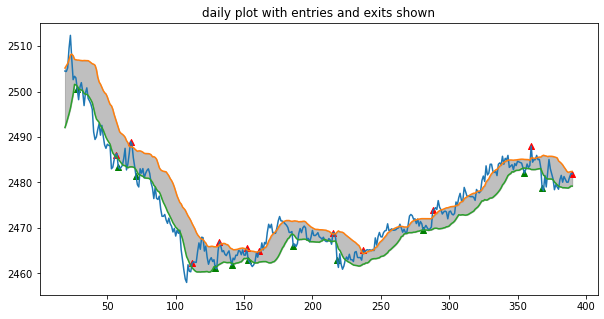

--------------------summary for 2023-08-02 --------------------
            start_time             end_time      reason
0  2023-08-02 09:56:00  2023-08-02 10:23:00  Upper band
1  2023-08-02 10:32:00  2023-08-02 10:49:00  Upper band
2  2023-08-02 11:07:00  2023-08-02 11:23:00  Upper band
3  2023-08-02 11:31:00  2023-08-02 12:21:00   Stop loss
4  2023-08-02 12:29:00  2023-08-02 12:35:00  Upper band
5  2023-08-02 12:53:00  2023-08-02 13:12:00  Upper band
6  2023-08-02 13:16:00  2023-08-02 13:55:00  Upper band
7  2023-08-02 13:59:00  2023-08-02 14:36:00  Upper band
8  2023-08-02 15:22:00  2023-08-02 15:30:00  End of Day


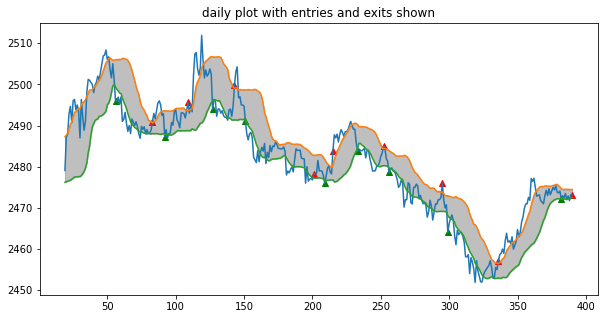

--------------------summary for 2023-08-07 --------------------
             start_time             end_time      reason
0   2023-08-07 09:19:00  2023-08-07 10:04:00  Upper band
1   2023-08-07 10:19:00  2023-08-07 10:28:00  Upper band
2   2023-08-07 10:50:00  2023-08-07 10:54:00  Upper band
3   2023-08-07 11:18:00  2023-08-07 11:24:00  Upper band
4   2023-08-07 11:34:00  2023-08-07 11:47:00  Upper band
5   2023-08-07 11:58:00  2023-08-07 12:11:00  Upper band
6   2023-08-07 12:16:00  2023-08-07 12:32:00  Upper band
7   2023-08-07 12:56:00  2023-08-07 13:04:00  Upper band
8   2023-08-07 13:14:00  2023-08-07 13:29:00  Upper band
9   2023-08-07 13:59:00  2023-08-07 14:06:00  Upper band
10  2023-08-07 14:08:00  2023-08-07 14:14:00  Upper band
11  2023-08-07 14:33:00  2023-08-07 14:42:00  Upper band
12  2023-08-07 15:01:00  2023-08-07 15:29:00  Upper band


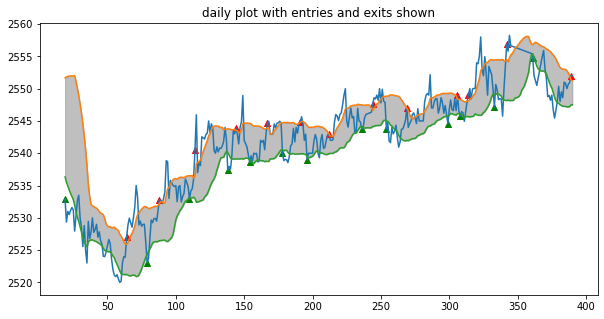

--------------------summary for 2023-07-28 --------------------
            start_time             end_time      reason
0  2023-07-28 09:34:00  2023-07-28 09:39:00  Upper band
1  2023-07-28 10:30:00  2023-07-28 10:41:00  Upper band
2  2023-07-28 10:59:00  2023-07-28 11:02:00  Upper band
3  2023-07-28 11:13:00  2023-07-28 11:49:00  Upper band
4  2023-07-28 11:52:00  2023-07-28 11:59:00  Upper band
5  2023-07-28 12:03:00  2023-07-28 12:21:00  Upper band
6  2023-07-28 12:54:00  2023-07-28 13:00:00  Upper band
7  2023-07-28 13:41:00  2023-07-28 14:02:00  Upper band
8  2023-07-28 14:38:00  2023-07-28 14:48:00  Upper band
9  2023-07-28 14:51:00  2023-07-28 15:30:00  End of Day


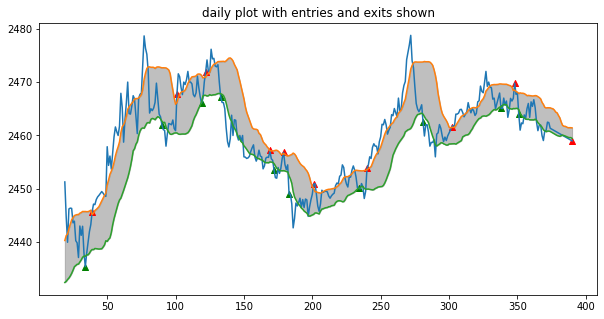

--------------------summary for 2023-08-10 --------------------
            start_time             end_time      reason
0  2023-08-10 09:47:00  2023-08-10 09:52:00  Upper band
1  2023-08-10 09:59:00  2023-08-10 10:08:00  Upper band
2  2023-08-10 10:24:00  2023-08-10 10:52:00  Upper band
3  2023-08-10 11:44:00  2023-08-10 12:07:00  Upper band
4  2023-08-10 13:25:00  2023-08-10 13:35:00  Upper band
5  2023-08-10 13:41:00  2023-08-10 14:04:00   Stop loss
6  2023-08-10 14:36:00  2023-08-10 14:42:00  Upper band
7  2023-08-10 15:01:00  2023-08-10 15:30:00  End of Day


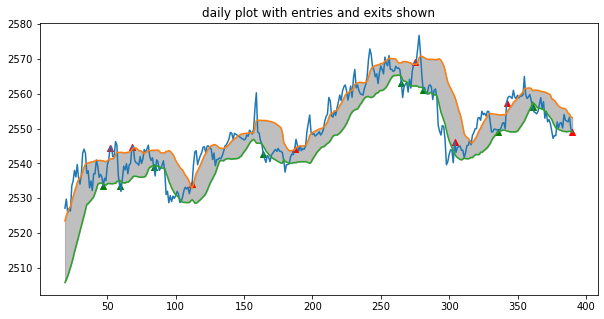

--------------------summary for 2023-08-08 --------------------
            start_time             end_time                  reason
0  2023-08-08 09:19:00  2023-08-08 09:32:00               Stop loss
1  2023-08-08 09:33:00  2023-08-08 09:37:00  Achieved Target Profit
2  2023-08-08 09:56:00  2023-08-08 10:08:00              Upper band
3  2023-08-08 10:32:00  2023-08-08 11:19:00               Stop loss
4  2023-08-08 11:22:00  2023-08-08 11:54:00              Upper band
5  2023-08-08 12:05:00  2023-08-08 12:42:00               Stop loss
6  2023-08-08 12:55:00  2023-08-08 13:01:00              Upper band
7  2023-08-08 13:16:00  2023-08-08 13:57:00              Upper band
8  2023-08-08 14:30:00  2023-08-08 15:24:00              Upper band


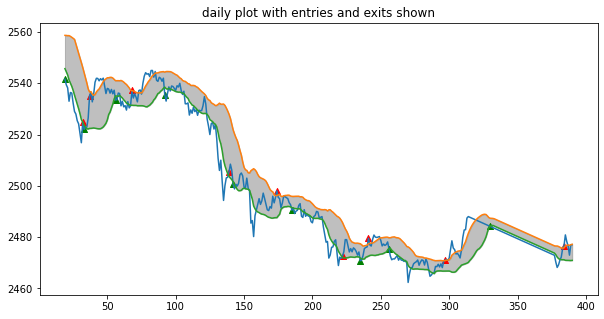

--------------------summary for 2023-08-11 --------------------
            start_time             end_time      reason
0  2023-08-11 09:19:00  2023-08-11 09:36:00  Upper band
1  2023-08-11 10:50:00  2023-08-11 11:10:00  Upper band
2  2023-08-11 11:38:00  2023-08-11 11:57:00  Upper band
3  2023-08-11 12:29:00  2023-08-11 12:46:00  Upper band
4  2023-08-11 12:51:00  2023-08-11 13:26:00  Upper band


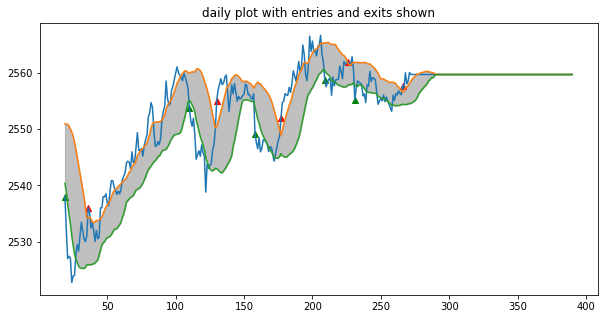

--------------------summary for 2023-08-03 --------------------
            start_time             end_time      reason
0  2023-08-03 09:36:00  2023-08-03 09:55:00  Upper band
1  2023-08-03 11:09:00  2023-08-03 11:27:00   Stop loss
2  2023-08-03 11:59:00  2023-08-03 12:34:00   Stop loss
3  2023-08-03 12:39:00  2023-08-03 13:14:00  Upper band
4  2023-08-03 13:19:00  2023-08-03 13:38:00  Upper band
5  2023-08-03 13:45:00  2023-08-03 14:13:00  Upper band
6  2023-08-03 14:52:00  2023-08-03 14:55:00  Upper band


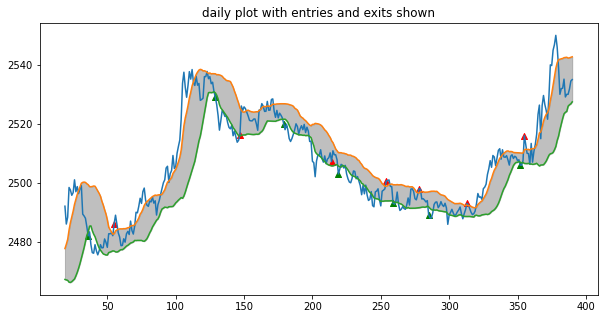

--------------------summary for 2023-08-04 --------------------
            start_time             end_time                  reason
0  2023-08-04 09:30:00  2023-08-04 09:34:00  Achieved Target Profit
1  2023-08-04 09:37:00  2023-08-04 09:54:00              Upper band
2  2023-08-04 10:21:00  2023-08-04 11:04:00              Upper band
3  2023-08-04 11:14:00  2023-08-04 11:42:00              Upper band
4  2023-08-04 12:03:00  2023-08-04 12:10:00              Upper band
5  2023-08-04 12:36:00  2023-08-04 12:59:00              Upper band
6  2023-08-04 13:14:00  2023-08-04 14:10:00              Upper band
7  2023-08-04 14:27:00  2023-08-04 14:31:00              Upper band
8  2023-08-04 14:52:00  2023-08-04 15:00:00              Upper band
9  2023-08-04 15:29:00  2023-08-04 15:30:00              End of Day


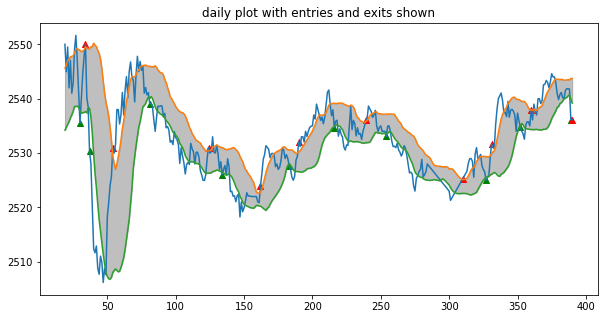

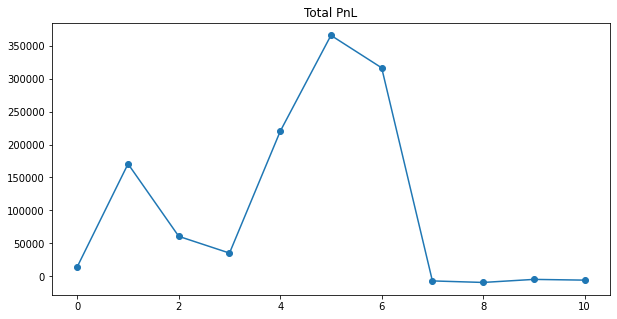

--------------------Stats--------------------
          Date number of trades number of winning trades  \
0   2023-07-31                9                        5   
1   2023-08-09               14                       13   
2   2023-08-01               11                        9   
3   2023-08-02                9                        5   
4   2023-08-07               13                       11   
5   2023-07-28               10                        7   
6   2023-08-10                8                        5   
7   2023-08-08                9                        3   
8   2023-08-11                5                        4   
9   2023-08-03                7                        4   
10  2023-08-04               10                        6   

   number of lossing trades  Average gain (winning)  Average loss (lossing)  \
0                         4                0.145960               -0.069828   
1                         1                0.223993               -0.001993

In [7]:
run(df , 'ADANIENT' , '' , '' , '1M' , 0.005 , 0.005 , 20 , 1)